In [1]:
# Import necessary packages
import networkx as nx
import pickle
import evaluate as ev
import numpy as np

Specify pickle file location here (of graph object list and properties list)

In [2]:
# Path location for saved data
savelocG=r"full_data/unitd_graphs_first_400(step_5).pkl"
savelocP=r"full_data/unitd_properties_first_400(step_5).pkl"

# save file for csv (unique to graphs)
#csv_save_loc = savelocG.split('_')[-5]
csv_save_loc =savelocG.split('/')[-1] + "num-clusters"
csv_save_loc='LPA_'+csv_save_loc
print(csv_save_loc)

LPA_unitd_graphs_first_400(step_5).pkl


In [3]:
# Load data from pickle files
with open(savelocG, "rb") as input_file:
    graphs = pickle.load(input_file)

with open(savelocP, "rb") as input_file:
    properties = pickle.load(input_file)
print(f'Loaded Graphs: {len(graphs)}\nLoaded Properties: {len(properties)}')

Loaded Graphs: 400
Loaded Properties: 400


In [4]:
#Slice
graphs=graphs[:100]
properties=properties[:100]

In [5]:
for i in properties:
    np.set_printoptions(suppress=True)
    print(i)

[5.  5.  2.  0.5]
[10.         22.          4.4         0.48888889]
[15.         45.          6.          0.42857143]
[20.         93.          9.3         0.48947368]
[ 25.   141.    11.28   0.47]
[ 30.         204.          13.6          0.46896552]
[ 35.         266.          15.2          0.44705882]
[ 40.         357.          17.85         0.45769231]
[ 45.         442.          19.64444444   0.44646465]
[ 50.         526.          21.04         0.42938776]
[ 55.         620.          22.54545455   0.41750842]
[ 60.         735.          24.5          0.41525424]
[ 65.         860.          26.46153846   0.41346154]
[  70.         1035.           29.57142857    0.42857143]
[  75.         1179.           31.44          0.42486486]
[  80.         1371.           34.275         0.43386076]
[  85.         1590.           37.41176471    0.44537815]
[  90.         1808.           40.17777778    0.45143571]
[  95.         2008.           42.27368421    0.44972004]
[ 100.        2198.   

[number of nodes, number of edges, avg_degree, density]

In [6]:
def print_properties(arr):
    str = "Properties\n"
    str += f"Nodes = {arr[0]} | "
    str += f"Edges = {arr[1]} | "
    str += f"Average Degree = {arr[2]} | "
    str += f"Density = {arr[3]} | "
    print(str)

def extract_properties(arr):
    return [int(arr[0]), int(arr[1]), arr[2], arr[3]]

Properties
Nodes = 5.0 | Edges = 5.0 | Average Degree = 2.0 | Density = 0.5 | 


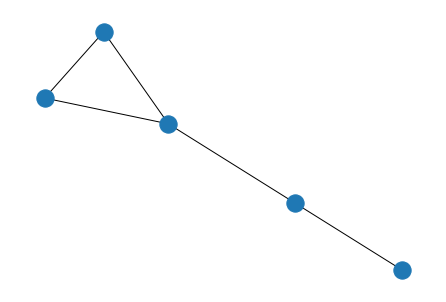

In [7]:
# Sanity check 
for g,p in zip(graphs, properties):
    nx.draw(g)
    print_properties(p)
    break

## HCS Algorithm 
#### Test graphs using HCS algorithm and analyze results

In [8]:
# Install dependency
# !pip install netgraph

In [9]:
from networkx.algorithms import community
from netgraph import Graph
import matplotlib.pyplot as plt
from hcs_module import HCS,labelled_HCS
import csvwriter as cvw

In [10]:
# Helper function to generate node-community dict for netgraph color function
def node_comm_dict(labels):
    out = dict()
    for (node, comm) in enumerate(labels):
        out[node] = comm
    return out


In [11]:
# Choose second graph in the array
G = graphs[2].copy()

In [12]:
# Check the HCS algorithm on a graph
HCS_G = HCS(G.copy())
labels, itr = labelled_HCS(G.copy())
node_to_community= node_comm_dict(labels)

cutratio = ev.cut_ratio(G,itr)
avg_internal_density= ev.avg_internal_density(G,itr)
coverage, performance = ev.cov_per(G,itr)
modularity = ev.modularity(G,itr)

print(extract_properties(properties[2]))
print(cutratio, avg_internal_density, coverage, performance, modularity)


[15, 45, 6.0, 0.42857142857142855]
0.35714285714285715 0 0.4 0.7142857142857143 0.031111111111111145


### Default function to run all graphs and cluster them

In [13]:
import timeit
from IPython.display import clear_output, display
def evaluate_graphs(graphs):
    csvwriter= cvw.CustomCSV(cols=cvw.CustomCSV.ALL_HEADER)
    results = []
    for idx, graph in enumerate(graphs):
        print(idx)
        G = graph.copy()
        
        # Clustering algorithm start
        start = timeit.default_timer()
        itr = community.label_propagation_communities(G)
        exec_time = timeit.default_timer() - start
        # end
        #print(exec_time)
        cutratio = ev.cut_ratio(G,itr)
        modularity = ev.modularity(G,itr)
        avg_internal_density= ev.avg_internal_density(G,itr)
        coverage, performance = ev.cov_per(G,itr)
        node_to_community= node_comm_dict(labels)
        # Number of clusters
        num_clusters = len([*itr])
        props = extract_properties(properties[idx])
        results.append([*props,cutratio, avg_internal_density,coverage, performance, modularity,exec_time,num_clusters])
        clear_output(wait=True)
    csvwriter.write_to_csv(data=results,filename=csv_save_loc)

evaluate_graphs(graphs=graphs)

> Sucessfully written to ./csvs/LPA_unitd_graphs_first_400(step_5).pkl ...


In [14]:
community_to_color = {
    0 : 'tab:blue',
    1 : 'tab:orange',
    2 : 'tab:green',
    3 : 'tab:red',
    4 : 'tab:pink',
    5 : 'tab:cyan',
    6 : 'tab:olive',
    7 : 'tab:purple',
    8 : 'tab:brown'
}
node_color = {node: community_to_color[community_id] for node, community_id in node_to_community.items()}

Graph(G,
      node_color=node_color, node_edge_width=0, edge_alpha=0.5,
      node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
      edge_layout='bundled'
)

plt.show()

KeyError: 9

In [14]:
# Helper function to draw both original and clustered graphs
def plot_graph_and_cluster(G, node_color_dict, key="HCS"):
    '''
      Input:
      G = The original graph
      node_color_dict = The clustered graph node community dict
      key = The name of the clustering algorithm
      
      Output: 
      void 
    '''
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Original Graph and Clustered Graph using '+ key)
    
    # Draw original graph
    nx.draw(G, ax=ax1)
    
    # Draw clusterd graph
    Graph(G,
      node_color=node_color, node_edge_width=0, edge_alpha=0.5,
      node_layout='community', node_layout_kwargs=dict(node_to_community=node_to_community),
      edge_layout='bundled',
      ax=ax2
    )
    plt.show()

In [15]:
#plot_graph_and_cluster(G, node_color)

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load csv file containing info
raw = pd.read_csv(f"./csvs/{csv_save_loc}.csv")
raw.head()

,Number of nodes,Number of Edges,Average Degree,Density,Cut-Ratio,Avg. internal density,Coverage,Performance,Modularity,Execution Time
0,5,5,2.00,0.500000,0.166667,1.000000,0.800000,0.900000,0.220000,0.000399
1,10,22,4.40,0.488889,0.000000,0.488889,1.000000,0.488889,0.000000,0.000167
2,15,45,6.00,0.428571,0.240741,0.697222,0.711111,0.695238,0.202222,0.000342
3,20,93,9.30,0.489474,0.000000,0.489474,1.000000,0.489474,0.000000,0.000448
4,25,141,11.28,0.470000,0.000000,0.470000,1.000000,0.470000,0.000000,0.000566


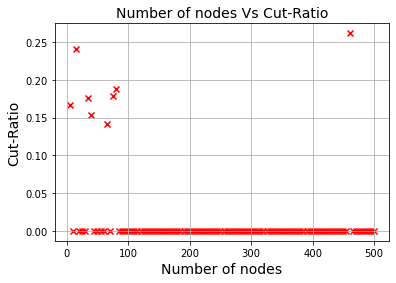

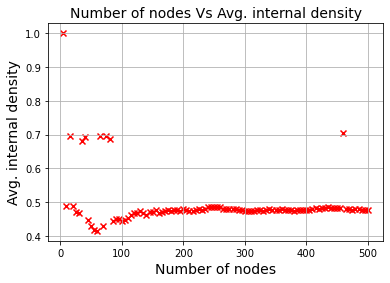

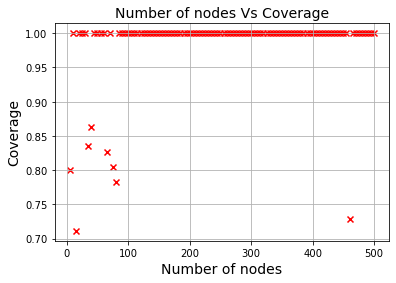

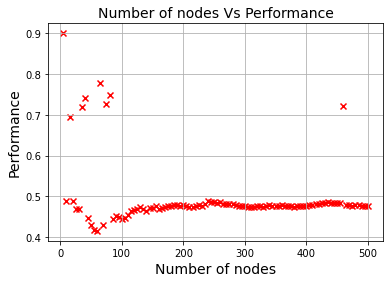

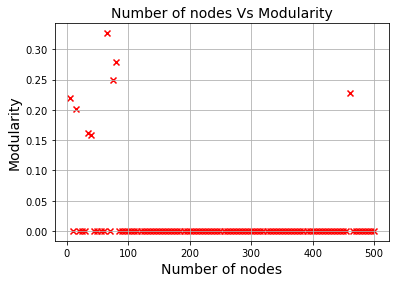

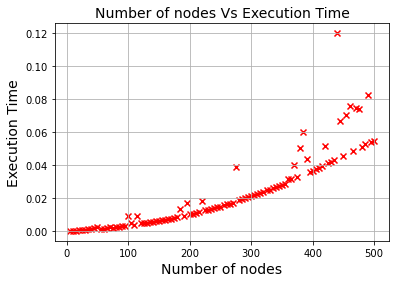

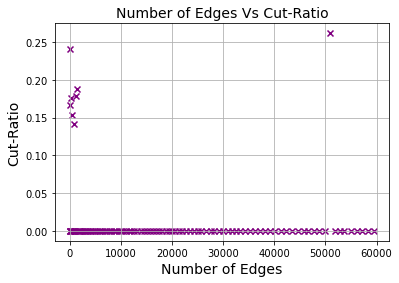

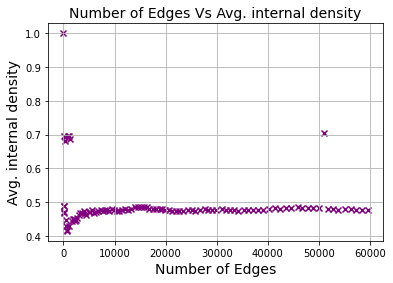

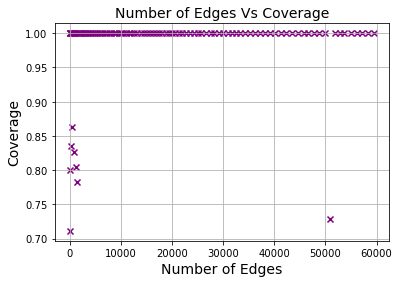

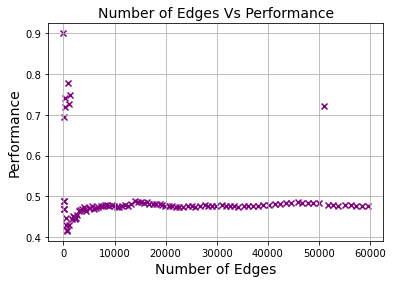

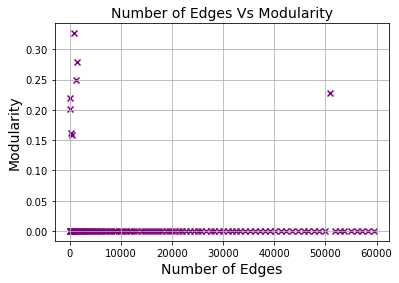

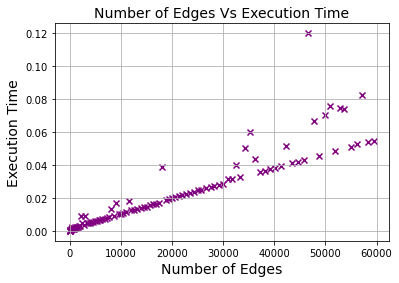

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
### Visualization for HCS algorithm
# Load csv file containing info
PERFOMANCE_METRICS = cvw.CustomCSV.PERFOMANCE_METRICS

for idx, metric in enumerate(PERFOMANCE_METRICS):

    # Plot node vs density
    plt.figure()
    plt.scatter(raw["Number of nodes"],raw[metric], color='red', marker='x')
    plt.title(f'Number of nodes Vs {metric}', fontsize=14)
    plt.xlabel('Number of nodes', fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.grid(True)
    plt.show()

for idx, metric in enumerate(PERFOMANCE_METRICS):

    # Plot edges vs density
    plt.figure()
    plt.scatter(raw["Number of Edges"],raw[metric], color='purple', marker='x')
    plt.title(f'Number of Edges Vs {metric}', fontsize=14)
    plt.xlabel('Number of Edges', fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.grid(True)
    plt.show()